# Code for large deformation magneto-viscoelasticity of s-MRE materials.

- Magnetic visco-dynamic actuation of a trilayer s-MRE beam.


Eric Stewart 

ericstew@mit.edu  

August 2024

### Units

- Basic:
    - Length: mm
    -   Time: s
    -   Mass: kg
    - Charge: kC
    
- Derived: 
    - Force: mN
    - Pressure: kPa
    - Current: kA
    - Mag. flux density: mT

### Software:
- Dolfinx v0.8.0

# Import modules

In [1]:
# Import FEnicSx/dolfinx
import dolfinx

# For numerical arrays
import numpy as np

# For MPI-based parallelization
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

# PETSc solvers
from petsc4py import PETSc

# specific functions from dolfinx modules
from dolfinx import fem, mesh, io, plot, log
from dolfinx.fem import (Constant, dirichletbc, Function, functionspace, Expression)
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import VTXWriter, XDMFFile


# specific functions from ufl modules
import ufl
from ufl import (TestFunctions, TrialFunction, Identity, grad, det, div, dev, inv, tr, sqrt, conditional ,\
                 gt, dx, inner, derivative, dot, ln, split, exp, eq, cos, sin, acos, ge, le, outer, tanh, cosh, atan, atan2)

# basix finite elements
import basix
from basix.ufl import element, mixed_element, quadrature_element

# Matplotlib for plotting
import matplotlib.pyplot as plt
plt.close('all')

# For timing the code
from datetime import datetime


# Set level of detail for log messages (integer)
# Guide:
# CRITICAL  = 50, // errors that may lead to data corruption
# ERROR     = 40, // things that HAVE gone wrong
# WARNING   = 30, // things that MAY go wrong later
# INFO      = 20, // information of general interest (includes solver info)
# PROGRESS  = 16, // what's happening (broadly)
# TRACE     = 13, // what's happening (in detail)
# DBG       = 10  // sundry
#
log.set_log_level(log.LogLevel.WARNING)

# Define geometry

In [2]:
# Geometry parameters
length = 20.0 # length of beam, mm
height = 1.0 # height of beam, mm
scale = 50  # side length of air domain, mm
 
# Read in the 2D mesh and cell tags
with XDMFFile(MPI.COMM_WORLD,"meshes/trilayer_beam.xdmf",'r') as infile:
    domain = infile.read_mesh(name="Grid",xpath="/Xdmf/Domain")
    cell_tags = infile.read_meshtags(domain,name="Grid")
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim-1)

# Also read in 1D facets for applying BCs
with XDMFFile(MPI.COMM_WORLD,"meshes/facet_trilayer_beam.xdmf",'r') as infile:
    facet_tags = infile.read_meshtags(domain,name="Grid")

# A single point for "grounding" the displacement and phi
def ground(x):
    return np.logical_and(np.isclose(x[0], -length), np.isclose(x[1], 0))
    

x = ufl.SpatialCoordinate(domain)

In [3]:
# # Identify the planar boundaries of the  box mesh
# #
# def left(x):
#     return np.isclose(x[0], -scale)
# def right(x):
#     return np.isclose(x[0], scale)
# def top(x):
#     return np.isclose(x[1], scale)
# def btm(x):
#     return np.isclose(x[1], -scale)
# #
# def beamLeft(x):
#     return np.logical_and(np.isclose(x[0], -length), np.greater_equal(x[1],-height/2 - 1e-2), np.less_equal(x[1], height/2 + 1e-2) )
# #

    
# # Mark the sub-domains
# boundaries = [(1, beamLeft), (2, left),(4,right), (5,top), (6,btm)]

# # build collections of facets on each subdomain and mark them appropriately.
# facet_indices, facet_markers = [], [] # initalize empty collections of indices and markers.
# fdim = domain.topology.dim - 1 # geometric dimension of the facet (mesh dimension - 1)
# for (marker, locator) in boundaries:
#     facets = mesh.locate_entities(domain, fdim, locator) # an array of all the facets in a 
#                                                          # given subdomain ("locator")
#     facet_indices.append(facets)                         # add these facets to the collection.
#     facet_markers.append(np.full_like(facets, marker))   # mark them with the appropriate index.

# # Format the facet indices and markers as required for use in dolfinx.
# facet_indices = np.hstack(facet_indices).astype(np.int32)
# facet_markers = np.hstack(facet_markers).astype(np.int32)
# sorted_facets = np.argsort(facet_indices)
# # 
# # Add these marked facets as "mesh tags" for later use in BCs.
# facet_tags = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

**Print out the unique cell index numbers**

In [4]:
top_imap = domain.topology.index_map(2)      # index map of 2D entities in domain
values = np.zeros(top_imap.size_global)      # an array of zeros of the same size as number of 2D entities
values[cell_tags.indices]=cell_tags.values # populating the array with facet tag index numbers
print(np.unique(cell_tags.values))          # printing the unique indices

[15 16 17]


**Print out the unique facet index numbers**

In [5]:
top_imap = domain.topology.index_map(1)      # index map of 2D entities in domain
values = np.zeros(top_imap.size_global)      # an array of zeros of the same size as number of 2D entities
values[facet_tags.indices]=facet_tags.values # populating the array with facet tag index numbers
print(np.unique(facet_tags.values))          # printing the unique indices

[12 13 14]


In [6]:
# 12: circle
# 13: Left edge of beam
# 14: Maxwell traction boundary

**Visualize reference configuration and boundary facets**

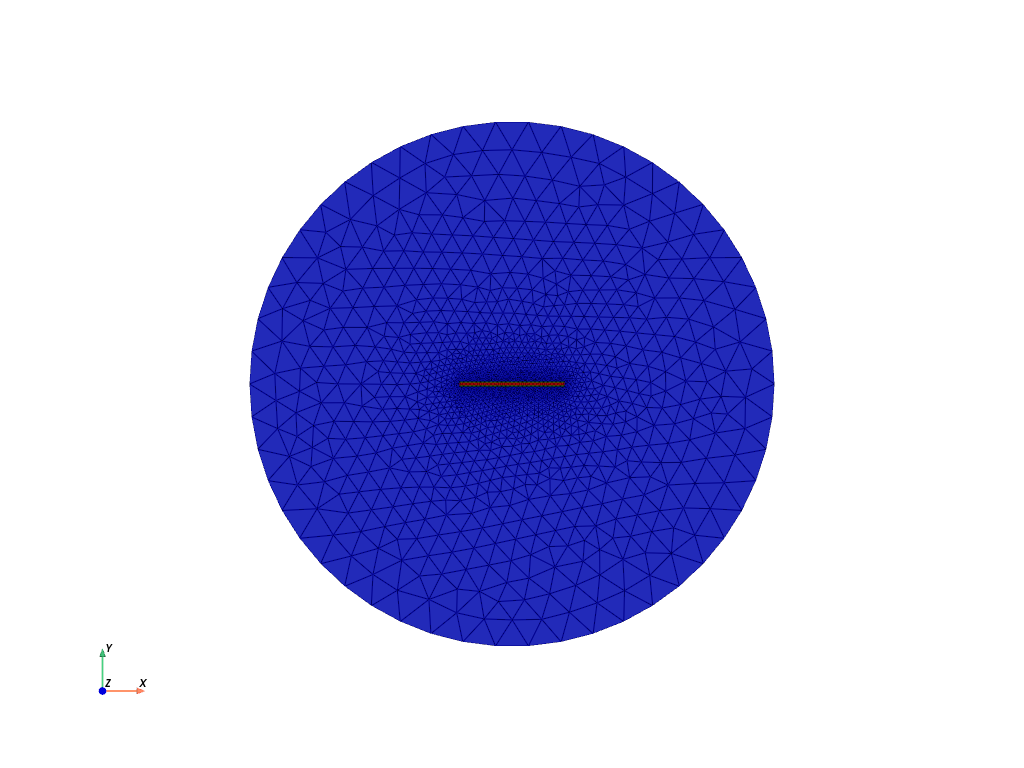

In [7]:
import pyvista
pyvista.set_jupyter_backend('html')
from dolfinx.plot import vtk_mesh
pyvista.start_xvfb()

# initialize a plotter
plotter = pyvista.Plotter()

# Add the mesh.
topology, cell_types, geometry = plot.vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
plotter.add_mesh(grid, show_edges=True, opacity=0.25) 

# Add colored 1D surfaces for the named surfaces
mre_surf = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim,cell_tags.indices[cell_tags.values==17]) )
plm_surf = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim,cell_tags.indices[cell_tags.values==16]) )
air_surf = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim,cell_tags.indices[cell_tags.values==15]) )
#
actor = plotter.add_mesh(mre_surf, show_edges=False,color="red") # mre is red
actor2 = plotter.add_mesh(plm_surf, show_edges=False,color="green") # polymer is green
actor3 = plotter.add_mesh(air_surf, show_edges=False,color="blue") # air is blue

plotter.view_xy()

labels = dict(zlabel='Z', xlabel='X', ylabel='Y')
plotter.add_axes(**labels)
    
plotter.screenshot("results/bilayer_mesh.png")

from IPython.display import Image
Image(filename='results/bilayer_mesh.png') 

## Define boundary and volume integration measure

In [8]:
# Define the boundary integration measure "ds" using the facet tags,
# also specify the number of surface quadrature points.
ds = ufl.Measure('dS', domain=domain, subdomain_data=facet_tags, metadata={'quadrature_degree':2})

# Define the volume integration measure "dx" 
# also specify the number of volume quadrature points.
dx = ufl.Measure('dx', domain=domain, subdomain_data=cell_tags, metadata={'quadrature_degree': 2})

# Create facet to cell connectivity required to determine boundary facets.
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim)
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim-1)
domain.topology.create_connectivity(domain.topology.dim-1, domain.topology.dim)

#  Define facet normal
n2D = ufl.FacetNormal(domain)
n = ufl.as_vector([n2D[0], n2D[1], 0.0])

# Material parameters

In [9]:
# A function for constructing spatially varying (piecewise-constant) material parameters

# Need some extra infrastructure for the spatially-discontinuous material property fields
Vmat = functionspace(domain, ("DG", 0)) # create a DG0 function space on the domain

def mat(prop_val_mre, prop_val_poly, prop_val_air):

    # Define an empty "prop" material parameter function,
    # which lives on the DG0 function space.
    prop = Function(Vmat)
    
    # Now, actualy assign the desired values of shear moduli to the new field.
    #
    coords = Vmat.tabulate_dof_coordinates()
    #
    # loop over the coordinates and assign the relevant material property, 
    # based on the local cell tag number.
    for i in range(coords.shape[0]):
        if cell_tags.values[i] == 17:
            prop.vector.setValueLocal(i, prop_val_mre)
        elif cell_tags.values[i] == 16:
            prop.vector.setValueLocal(i, prop_val_poly)
        else:
            prop.vector.setValueLocal(i, prop_val_air)
            
    return prop

In [10]:
# Elasticity parameters
Gshear   = mat(411.0, 375.0, 0.001) # Shear modulus, kPa
Kbulk    = mat(411.0e3, 375.0e3, 101.0) # Nearly-incompressible

# Viscoelasticity parameters
#
# These params are a decent fit for hysteresis data at f=0.1, 1.0, 10 Hz
matParams = [150, 0.0159, 100.0, 0.159, 100, 1.59]
#
Gneq_1  = Constant(domain, PETSc.ScalarType(matParams[0]))    #  Non-equilibrium shear modulus, kPa
tau_1   = Constant(domain, PETSc.ScalarType(matParams[1]))    #  relaxation time, s
#
Gneq_2  = Constant(domain, PETSc.ScalarType(matParams[2]))    #  Non-equilibrium shear modulus, kPa
tau_2   = Constant(domain, PETSc.ScalarType(matParams[3]))     #  relaxation time, s
#
Gneq_3  = Constant(domain, PETSc.ScalarType(matParams[4]))    #  Non-equilibrium shear modulus, kPa
tau_3   = Constant(domain, PETSc.ScalarType(matParams[5]))    #  relaxation time, s

# Coupling of shear modulus with magnetic field
zeta = mat(0.125, 0.0, 0.0)
xi   = Constant(domain, 8.37e-2) 

# Mass density
rho =  mat(2.833e-6, 1.045e-6, 0.0)  # 1e3 kg/m^3 = 1e-6 kg/mm^3

# Magnetization parameters 
#
# Vacuum permeability
mu0 = Constant(domain, 1.256e-6*1e9) # Vacuum permeability,  mN / mA^2
#
# material permeability (paramagnetic response)
chi = Constant(domain, 1.75) #chi = mat(1.75, 1.0e-3, 1.0e-3)# unitless magnetic susceptibility
mu  = mu0*(1.0 + chi) # magnetic permeability
ms  = Constant(domain, 0.495) # magnetic saturation value, kA/mm = MA/m

# Generalized-alpha method parameters
alpha   = Constant(domain, 0.0) # Set \alpha=0, since we observe no spurious pressure oscillations
gamma   = Constant(domain, PETSc.ScalarType(0.5+alpha))
beta    = Constant(domain, PETSc.ScalarType((gamma+0.5)**2/4.))

# Switch for whether to include viscous stresses
TviscoInd   = mat(1, 1, 0)
#
# Switch for whether the domain is the air (non-magnetic) or not
TairInd   = mat( 0, 1, 1)


# Simulation time-control related params

In [11]:
# Simulation time control-related params
t    = 0.0         # start time (s)
h_app_mag = 0.040 # final h-field, 40 kA/m = 0.040 kA/mm.

# input tabular data for time signal
times = np.array([0, 0.20, 0.25, 0.45, 0.50, 1.00])
amps  = np.array([0, 0.00, 1.00, 1.00, 0.00, 0.00])

# Total time for stretching signal
Ttot = np.max(times)
# time step size
numSteps = 300
dt = Ttot/numSteps
# Create a constant for the time step
dk = Constant(domain, PETSc.ScalarType(dt))

# Function to apply desired displacement signal
def hRamp(t):
    
    # interpolate the amplitude from the tabular data
    hAmp = np.interp(t, times, amps)
    
    # multiply the amplitude by uMax.
    h_mag_val = h_app_mag*hAmp
     
    return h_mag_val

# Vector of applied h field
angleDegrees = 35.0  # angle of inclination of h-field versus e_2
theta  = Constant(domain, PETSc.ScalarType(angleDegrees*np.pi/180.0)) 
h_cons = Constant(domain, PETSc.ScalarType(hRamp(t)))


# Function spaces

In [12]:

U2 = element("Lagrange", domain.basix_cell(), 2, shape=(2,))  # For displacement
P1 = element("DG", domain.basix_cell(), 0)  # For pressure (must be DG to accomodate different materials)
P2 = element("Lagrange", domain.basix_cell(), 2)  # For phi
# P0 = element("Lagrange", domain.basix_cell(), 1)  
# T0 = element("Lagrange", domain.basix_cell(), 1, shape=(3,3))  
P0 = quadrature_element(domain.basix_cell(), degree=2, scheme="default") 
# Note: it seems that for the current version of dolfinx, 
# only degree=2 quadrature elements actually function properly 
# in e.g. visualization interpolations and problem solution.
T0 = basix.ufl.blocked_element(P0, shape=(3,3)) # for Cv
#
TH = mixed_element([U2, P1, P2])     # Taylor-Hood style mixed element
ME = functionspace(domain, TH)    # Total space for all DOFs
#
V1 = functionspace(domain, P1) # Scalar function space.
V1_2 = functionspace(domain, P2) # Scalar (quadratic) function space.
V2 = functionspace(domain, U2) # Vector function space
V3 = functionspace(domain, T0) # Tensor function space
#
# Define actual functions with the required DOFs
w         = Function(ME)
u, p, phi = split(w)  

# A copy of functions to store values in the previous step
w_old              = Function(ME)
u_old,  p_old, phi_old = split(w_old)   

# Define test functions        
u_test, p_test, phi_test = TestFunctions(ME)    

# Define trial functions needed for automatic differentiation
dw = TrialFunction(ME)  

# Define a tensor-valued function for Cv.
Cv_1_old = Function(V3) 
Cv_2_old = Function(V3) 
Cv_3_old = Function(V3) 

# Functions for storing the velocity and acceleration at prev. step
v_old = Function(V2)
a_old = Function(V2)

# Initial conditions: 

# A function for constructing the identity matrix.
#
# To use the interpolate() feature, this must be defined as a 
# function of x.
def identity(x):
    values = np.zeros((3*3,
                      x.shape[1]), dtype=np.float64)
    values[0] = 1
    values[4] = 1
    values[8] = 1
    return values

# interpolate the identity onto the tensor-valued Cv function.
Cv_1_old.interpolate(identity)  
Cv_2_old.interpolate(identity)  
Cv_3_old.interpolate(identity)  

# Subroutines for kinematics and constitutive equations

In [13]:
#------------------------------------------------------------- 
# Utility subroutines
#-------------------------------------------------------------
 
# Subroutine for a "safer" sqrt() function which avoids a divide by zero 
# when automatically differentiated. 
def safe_sqrt(x):
    return sqrt(x + 1.0e-16)

# Hyperbolic secant function
def sech(x):
    return 1.0/cosh(x)

# Macaulay bracket function
def ppos(x):
    return (x+abs(x))/2.

#-------------------------------------------------------
# Subroutines for plane strain
#-------------------------------------------------------

# Special gradient operators for plane strainfunctions 
#
# Gradient of vector field u   
def pe_grad_vector(u):
    
    grad_u = grad(u)
    
    pe_grad_u = ufl.as_tensor([ [grad_u[0,0], grad_u[0,1], 0.0],
                                [grad_u[1,0], grad_u[1,1], 0.0],
                                [        0.0,         0.0, 0.0] ]) 
    
    return pe_grad_u

# Gradient of scalar field y
# (just need an extra zero for dimensions to work out)
def pe_grad_scalar(y):
    
    grad_y = grad(y)
    
    pe_grad_y = ufl.as_vector([grad_y[0], grad_y[1], 0.0])
    
    return pe_grad_y

# Axisymmetric deformation gradient 
def F_pe_calc(u):
    
    dim = len(u)                # dimension of problem (2)
    
    Id = Identity(dim)          # 2D Identity tensor
    
    F = Id + grad(u)            # 2D Deformation gradient
      
    F_pe =  ufl.as_tensor([ [F[0,0], F[0,1], 0.0],
                            [F[1,0], F[1,1], 0.0],
                            [   0.0,    0.0, 1.0] ]) # Full plane strain F
    
    return F_pe

def h_calc(u, phi):
    
    F = F_pe_calc(u)
    
    h_R = -pe_grad_scalar(phi)
    
    h_sp = inv(F.T)*h_R
    
    return h_sp

#------------------------------------------------------------- 
# Subroutines for computing the viscous flow update
#-------------------------------------------------------------

# subroutine for the distortional part / unimodular part of a tensor A
def dist_part(A):

    Abar = A / (det(A)**(1.0/3.0))

    return Abar

# Subroutine for computing the viscous stretch Cv at the end of the step.
def Cv_update(u, Cv_old, tau_r):
    
   F = F_pe_calc(u)
   
   J = det(F)
   
   C = F.T*F
   
   Cv_new = dist_part( Cv_old + ( dk / tau_r ) * J**(-2./3.) * C ) 
    
   return Cv_new

#------------------------------------------------------------- 
# Subroutines for calculating the equilibrium Piola stress
#-------------------------------------------------------------

# Subroutine for the functional dependence of the shear modulus on the magnetic field
def Phi_calc(phi):

    h_R = -pe_grad_scalar(phi)

    h_R_norm = safe_sqrt( dot(h_R, h_R) )

    Phi = 1.0 + zeta * tanh( ppos(h_R_norm) / xi) 

    return Phi

# Subrountine for computing the effective stretch
def lambdaBar_calc(u):
    
    F = F_pe_calc(u)
    
    J = det(F)
    
    Fbar = J**(-1/3)*F
    
    Cbar = Fbar.T*Fbar
    
    I1 = tr(Cbar)
    
    lambdaBar = safe_sqrt(I1/3.0)
    
    return lambdaBar

# Subroutine for calculating the  equilibrium Cauchy stress
def T_eq_calc(u,p,phi):
    
    F   = F_pe_calc(u)
    
    J = det(F)
    
    Fbar = J**(-1/3)*F
    
    Bbar = Fbar*Fbar.T

    Phi = Phi_calc(phi)
    
    T_eq = (1/J) * Phi * Gshear * dev(Bbar) - p * Identity(3)
    
    return T_eq

# Subroutine for the non-equilibrium Cauchy stress.
def T_neq_calc(u, Cv, Gneq):
        
    F  = F_pe_calc(u)
    
    J = det(F)
    
    C = F.T*F
    
    T_neq = J**(-5./3.) * Gneq * (F * inv(Cv) * F.T - (1./3.) * inner(C, inv(Cv)) * Identity(3) ) 
    
    return T_neq

# Subroutine for calculating the Magnetic Cauchy stress
def T_mag_calc(u, phi):
    
    h_sp = h_calc(u, phi)
    
    h_norm = safe_sqrt( dot(h_sp, h_sp) ) 
    
    T_mag_maxw = mu0 * (outer(h_sp, h_sp) - (1./2.) * dot(h_sp, h_sp) * Identity(3) )
    
    T_mag_para = - mu0 * ( (ms**2) / chi ) * ln( cosh( ( chi / ms ) * h_norm ) ) * Identity(3) \
                 + mu0 * ( ms / ( h_norm + 1.0e-3) ) * tanh( ( chi / ms ) * h_norm ) * outer(h_sp, h_sp)
    
    # Exclude the paramagnetic response in the air domain.
    T_mag = T_mag_maxw + conditional(eq(TairInd,1), 0.0*Identity(3), T_mag_para)
    
    return T_mag


def Piola_calc(u, p, phi, Cv_1, Cv_2, Cv_3, Gneq_1, Gneq_2, Gneq_3):
    
    F = F_pe_calc(u)
    
    J = det(F)
    
    T_eq = T_eq_calc(u, p, phi)

    T_neq_1 = T_neq_calc(u, Cv_1, Gneq_1)
    
    T_neq_2 = T_neq_calc(u, Cv_2, Gneq_2)

    T_neq_3 = T_neq_calc(u, Cv_3, Gneq_3)
    
    T_mag = T_mag_calc(u, phi)
    
    T = T_eq + conditional(eq(TairInd,1), 0.0*Identity(3), T_mag) +   \
        conditional(eq(TviscoInd,0), 0.0*Identity(3), T_neq_1 + T_neq_2 + T_neq_3 )

    Piola = J * T * inv(F.T)
    
    return Piola

#------------------------------------------------------------- 
# Subroutines for calculating the magnetic flux density
#-------------------------------------------------------------


def b_R_calc(u, phi):

    F = F_pe_calc(u)
    
    J = det(F)
    
    h_sp = h_calc(u, phi)
    
    h_norm = safe_sqrt( dot(h_sp, h_sp) )
    
    b_maxw = mu0 * h_sp

    # Shear modulus-dependence term:

    B = F*F.T

    I1_bar = tr( J**(-2.0/3.0) * B)

    h_B_norm = safe_sqrt( dot(h_sp, B*h_sp) )

    b_Gshr = - ( zeta / (xi * ( h_B_norm + 1.0e-3) ) ) * ( sech(h_B_norm/xi) )**(2.0) * (Gshear/2.0) * (I1_bar - 3.0) * J**(-1) * B * h_sp 
    
    b_para = mu0 * ( ms / (h_norm + 1.0e-3) ) * tanh( ( chi / ms ) * h_norm ) * h_sp
    
    # Exclude the paramagnetic response in the air domain.
    b_sp = b_maxw + conditional(eq(TairInd,1), ufl.as_vector([0.,0.,0.]), b_para + b_Gshr)
    
    b_R = J * inv(F) * b_sp
    
    return b_R

def Cauchy_out(u, phi):

    # Calculate the Maxwell stress in the air
    h_sp = h_calc(u, phi)
    
    T_max = mu0 * (outer(h_sp, h_sp) - (1./2.) * dot(h_sp, h_sp) * Identity(3) )

    return T_max

#---------------------------------------------------------------------
# Subroutine for updating  acceleration using the Newmark beta method:
# a = 1/(2*beta)*((u - u0 - v0*dt)/(0.5*dt*dt) - (1-2*beta)*a0)
#---------------------------------------------------------------------
def update_a(u, u_old, v_old, a_old):
    return (u-u_old-dk*v_old)/beta/dk**2 - (1-2*beta)/2/beta*a_old

#---------------------------------------------------------------------
# Subroutine for updating  velocity using the Newmark beta method
# v = dt * ((1-gamma)*a0 + gamma*a) + v0
#---------------------------------------------------------------------
def update_v(a, u_old, v_old, a_old):
    return v_old + dk*((1-gamma)*a_old + gamma*a)

#---------------------------------------------------------------------
# alpha-method averaging function
#---------------------------------------------------------------------
def avg(x_old, x_new, alpha):
    return alpha*x_old + (1-alpha)*x_new

# Evaluate kinematics and constitutive relations

In [14]:
# Get acceleration and velocity at end of step
a_new = update_a(u, u_old, v_old, a_old)
v_new = update_v(a_new, u_old, v_old, a_old)

# get avg (u,p) fields for generalized-alpha method
u_avg  = avg(u_old, u, alpha)
p_avg  = avg(p_old, p, alpha)
phi_avg  = avg(phi_old, phi, alpha)

# kinematical quantities
F  = F_pe_calc(u_avg)
J  = det(F)
lambdaBar = lambdaBar_calc(u_avg)

# update the Cv tensors
Cv_1 = Cv_update(u_avg, Cv_1_old, tau_1)
Cv_2 = Cv_update(u_avg, Cv_2_old, tau_2)
Cv_3 = Cv_update(u_avg, Cv_3_old, tau_3)

#  Evaulate the total Piola stress
Piola = Piola_calc(u_avg, p_avg, phi_avg, Cv_1, Cv_2, Cv_3, Gneq_1, Gneq_2, Gneq_3)

# Evaluate the magnetic flux density
b_R = b_R_calc(u_avg, phi_avg)

# Weak forms

In [15]:
# 12: circle
# 13: Left edge of beam
# 14: Maxwell traction boundary

In [16]:
# Where TairInd on the '+' side is equal to 1, the '-' side indicates the MRE. 
# Thus we use the following form of the maxwell traction, where:
# -> J, F, and n are those of the MRE on the '-' side.
# -> Cauchy_out is that of the Air on the '+' side.
#
# The leading factor of TairInd('+') acts as a conditional, 
# which makes sure that this traction is zero where the MRE is on the '+' side.
#
maxw_trac_plus = TairInd('+')*dot(J('-')*Cauchy_out(u_avg, phi_avg)('+')*inv(F.T)('-'),n('-'))

# Where TairInd on the '-' side is equal to 1, the '+' side indicates the MRE. 
# Thus we use the following form of the maxwell traction, where:
# -> J, F, and n are those of the MRE on the '+' side.
# -> Cauchy_out is that of the Air on the '-' side.
#
# The leading factor of TairInd('-') acts as a conditional, 
# which makes sure that this traction is zero where the MRE is on the '-' side.
#
maxw_trac_minus = TairInd('-')*dot(J('+')*Cauchy_out(u_avg, phi_avg)('-')*inv(F.T)('+'),n('+'))

# The total maxwell traction on ds_out will be the contribution of both of these terms, where:
# -> maxw_trac_plus applies on portions of ds_out where the air is on the '+' side
# -> maxw_trac_minus applies on portions of ds_out where the air is on the '-' side
# -> the whole boundary must have one of these two conditions, so together they cover the whole domain. 
#
maxw_trac = maxw_trac_plus + maxw_trac_minus

In [17]:
g_grav = ufl.as_vector([0.0, -9.81e3])

In [18]:
# The weak form for the equilibrium equation
Res_1  =  inner( Piola, pe_grad_vector(u_test))*dx \
    - inner(maxw_trac, ufl.avg(ufl.as_vector([u_test[0], u_test[1], 0.0])) )*ds(14) \
    + inner(rho * a_new, u_test)*dx \
    - inner(rho * g_grav, u_test)*dx 

# The auxiliary equation for the pressure
#
Res_2 = inner((J-1) + p_avg/Kbulk, p_test)*dx

# Weak form of Gauss's Law for magnetism
Res_3 = inner( b_R,  pe_grad_scalar(phi_test) )*dx 

# The total residual
Res = Res_1 + Res_2 + Res_3 

# Automatic differentiation tangent:
a = derivative(Res, w, dw)

# Set-up output files

In [19]:
# results file name
results_name = "trilayer_air_dyn"

# Function space for projection of results
P1 = element("DG", domain.basix_cell(), 1)
VV1 = fem.functionspace(domain, P1) # linear scalar function space
#
U1 = element("DG", domain.basix_cell(), 1, shape=(2,)) 
VV2 = fem.functionspace(domain, U1) # linear Vector function space
#
T1 = element("DG", domain.basix_cell(), 1, shape=(3,3)) 
VV3 = fem.functionspace(domain, T1) # linear tensor function space


# For visualization purposes, we need to re-project the stress tensor onto a linear function space before 
# we write it (and its components and the von Mises stress, etc) to the VTX file. 
#
# This is because the stress is a complicated "mixed" function of the (quadratic Lagrangian) displacements
# and the (quadrature representation) plastic strain tensor and scalar equivalent plastic strain. 
#
# Create a linear problem for projecting the stress tensor onto the linear tensor function space VV3.


def setup_projection(u, V):

    trial = ufl.TrialFunction(V)
    test  = ufl.TestFunction(V)   

    a = ufl.inner(trial, test)*dx
    L = ufl.inner(u, test)*dx

    projection_problem = dolfinx.fem.petsc.LinearProblem(a, L, [], \
        petsc_options={"ksp_type": "cg", "ksp_rtol": 1e-16, "ksp_atol": 1e-16, "ksp_max_it": 1000})
    
    return projection_problem

Piola_projection = setup_projection(Piola, VV3)
Piola_temp = Piola_projection.solve()

T     = Piola*F.T/J

T22_projection = setup_projection(T[1,1], VV1)
T22_temp = T22_projection.solve()
T22_temp.name = "T22 projection"

p_proj = setup_projection(p, VV1)
p_vis = p_proj.solve()
p_vis.name = "p"


In [20]:
# primary fields to write to output file
u_vis      = Function(VV2, name="disp")
# p_vis      = Function(VV1, name="p")
phi_vis    = Function(VV1, name="phi")

In [21]:

# Mises stress
T     = Piola_temp*F.T/J
T0    = T - (1/3)*tr(T)*Identity(3)
Mises = sqrt((3/2)*inner(T0, T0))
Mises_vis= Function(VV1,name="Mises")
Mises_expr = Expression(Mises,VV1.element.interpolation_points())

# Cauchy stress components
T11 = Function(VV1)
T11.name = "T11"
T11_expr = Expression(T[0,0],VV1.element.interpolation_points())

T12 = Function(VV1)
T12.name = "T12"
T12_expr = Expression(T[0,1],VV1.element.interpolation_points())

T22 = Function(VV1)
T22.name = "T22"
T22_expr = Expression(T[1,1],VV1.element.interpolation_points())

T33 = Function(VV1)
T33.name = "T33"
T33_expr = Expression(T[2,2],VV1.element.interpolation_points())


In [22]:
# Effective stretch
lambdaBar_vis      = Function(VV1)
lambdaBar_vis.name = "LambdaBar"
lambdaBar_expr     = Expression(lambdaBar, VV1.element.interpolation_points())

# Volumetric deformation
J_vis      = Function(VV1)
J_vis.name = "J"
J_expr     = Expression(J, VV1.element.interpolation_points())

In [23]:
# air flag
TairInd_vis      = Function(VV1)
TairInd_vis.name = "Air flag"
TairInd_expr     = Expression(TairInd, VV1.element.interpolation_points())

# visco flag
TviscoInd_vis      = Function(VV1)
TviscoInd_vis.name = "Visco flag"
TviscoInd_expr     = Expression(TviscoInd, VV1.element.interpolation_points())

In [24]:
# h-, b-, and m-fields
h_vis      = Function(VV2)
h_vis.name = "h-field"
h_sp       = h_calc(u, phi)
h_2D       = ufl.as_vector([h_sp[0], h_sp[1]])
h_vis_expr = Expression(h_2D, VV2.element.interpolation_points())
#
b_vis      = Function(VV2)
b_vis.name = "b-field, T"
b_sp       = (F * b_R_calc(u, phi) / J)/1e3
b_2D       = ufl.as_vector([b_sp[0], b_sp[1]])
b_vis_expr = Expression(b_2D, VV2.element.interpolation_points())
#
m_vis      = Function(VV2)
m_vis.name = "m-field"
m_sp       = b_sp*1e3/mu0 - h_sp
m_2D       = ufl.as_vector([m_sp[0], m_sp[1]])
m_vis_expr = Expression(m_2D, VV2.element.interpolation_points())

# Magnitude of magnetic fields
h_mag_vis      = Function(VV1)
h_mag_vis.name = "h-field magnitude"
h_mag          = safe_sqrt(dot(h_sp, h_sp))
h_mag_expr     = Expression(h_mag, VV1.element.interpolation_points())
#
b_mag_vis      = Function(VV1)
b_mag_vis.name = "b-field magnitude, T"
b_mag          = safe_sqrt(dot(b_sp, b_sp))
b_mag_expr     = Expression(b_mag, VV1.element.interpolation_points())
#
m_mag_vis      = Function(VV1)
m_mag_vis.name = "m-field magnitude"
m_mag          = safe_sqrt(dot(m_sp, m_sp))
m_mag_expr     = Expression(m_mag, VV1.element.interpolation_points())

# induced h- and b-fields
#
# Constant for applied h-field
h_cons = Constant(domain,PETSc.ScalarType(hRamp(0)))
#
h_ind_vis      = Function(VV2)
h_ind_vis.name = "Induced h-field"
h_ind_sp       = h_calc(u, phi) - ufl.as_vector([0, h_cons, 0])
h_ind_2D       = ufl.as_vector([h_ind_sp[0], h_ind_sp[1]])
h_ind_vis_expr = Expression(h_ind_2D, VV2.element.interpolation_points())
#
b_ind_vis      = Function(VV2)
b_ind_vis.name = "Induced b-field, T"
b_ind_sp       = (F * b_R_calc(u, phi) / J - mu0 * ufl.as_vector([0, h_cons, 0]))/1e3
b_ind_2D       = ufl.as_vector([b_ind_sp[0], b_ind_sp[1]])
b_ind_vis_expr = Expression(b_ind_2D, VV2.element.interpolation_points())

In [25]:
# set up the output VTX files.
file_results = VTXWriter(
    MPI.COMM_WORLD,
    "results/" + results_name + ".bp",
    [  # put the functions here you wish to write to output
        u_vis, p_vis, phi_vis, # DOF outputs
        Mises_vis, T11, T12, T22_temp, T33, # stress outputs
        lambdaBar_vis, J_vis, # Kinematical outputs
        TairInd_vis, TviscoInd_vis, # material params
        h_vis, b_vis, m_vis, h_ind_vis, b_ind_vis, # magnetic outputs
    ],
    engine="BP4",
)

def writeResults(t):
    
    # Update the output fields before writing to VTX.
    #
    u_vis.interpolate(w.sub(0))
    # p_vis.interpolate(w.sub(1))
    p_vis = p_proj.solve()
    phi_vis.interpolate(w.sub(2))
    #
    # re-project to smooth visualization of quadrature functions
    # before interpolating.
    Piola_temp = Piola_projection.solve()
    T22_temp = T22_projection.solve()
    Mises_vis.interpolate(Mises_expr)
    T11.interpolate(T11_expr)
    T12.interpolate(T12_expr)
    T22.interpolate(T22_expr)
    T33.interpolate(T33_expr)
    #
    lambdaBar_vis.interpolate(lambdaBar_expr)
    J_vis.interpolate(J_expr)
    #
    TairInd_vis.interpolate(TairInd_expr)
    TviscoInd_vis.interpolate(TviscoInd_expr)
    #
    h_vis.interpolate(h_vis_expr)
    b_vis.interpolate(b_vis_expr)
    m_vis.interpolate(m_vis_expr)
    #
    h_mag_vis.interpolate(h_mag_expr)
    b_mag_vis.interpolate(b_mag_expr)
    m_mag_vis.interpolate(m_mag_expr)
    #
    h_ind_vis.interpolate(h_ind_vis_expr)
    b_ind_vis.interpolate(b_ind_vis_expr)
       
    # Finally, write output fields to VTX.
    #
    file_results.write(t) 

In [26]:
P1_Lg = element("Lagrange", domain.basix_cell(), 1)
VV1_Lg = fem.functionspace(domain, P1_Lg) # linear lagrange scalar function space
TviscoInd_lg_vis = Function(VV1_Lg, name="Air flag")

U1_Lg = element("Lagrange", domain.basix_cell(), 1, shape=(2,)) 
VV2_Lg = fem.functionspace(domain, U1_Lg) # linear lagrange Vector function space
u_lg_vis = Function(VV2_Lg, name="disp")

In [27]:
# set up the output VTX files.
file_results_bound = VTXWriter(
    MPI.COMM_WORLD,
    "results/" + results_name + "_boundary.bp",
    [  # put the functions here you wish to write to output
        u_lg_vis, TviscoInd_lg_vis,
    ],
    engine="BP4",
)

def writeResults_bound(t):
    
    # Update the output fields before writing to VTX.
    #
    u_lg_vis.interpolate(w.sub(0))
    TviscoInd_lg_vis.interpolate(TviscoInd_expr)
    
    # Finally, write output fields to VTX.
    #
    file_results_bound.write(t) 

# Infrastructure for pulling out time history data (force, displacement, etc.)

In [28]:
# infrastructure for evaluating functions at a certain point efficiently
pointForEval = np.array([length/2, 0, 0.0])
bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, pointForEval)
colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, pointForEval).array
#
# infrastructure for evaluating functions at a certain point efficiently
pointForEval2 = np.array([0, height/4, 0.0])
cell_candidates2 = dolfinx.geometry.compute_collisions_points(bb_tree, pointForEval2)
colliding_cells2 = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates2, pointForEval2).array

## Boundary condtions

In [29]:
# Setting up the expression for the phi boundary condition.
phi_val = - dot(ufl.as_vector([h_cons*sin(theta), h_cons*cos(theta), 0.0]), ufl.as_vector((x[0], x[1], 0.0)))

# interpolate the phi expression onto the proper function space
Vphi, Vphi_to_ME =  ME.sub(2).collapse() #Scalar function space corresponding to phi
#
phi_exp          = Expression(phi_val,Vphi.element.interpolation_points())
#
phi_prescribe    = Function(Vphi)
#
phi_prescribe.interpolate(phi_exp)

In [30]:
# Constant for applied displacement
# disp_cons = Constant(domain,PETSc.ScalarType(dispRamp(0)))

# Find the specific DOFs which will be constrained, recalling:
# 12: circle
# 13: Left edge of beam
# 14: Maxwell traction boundary

# First, the beam DOFs
left_u1_dofs = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(13))
left_u2_dofs = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(13))

# Now, the displacement DOFs for the air edge
sides_u1_dofs = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(12))
sides_u2_dofs = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(12))

# finally, the phi DOFs for the air edge
sides_phi_dofs = fem.locate_dofs_topological((ME.sub(2), Vphi), facet_tags.dim, facet_tags.find(12))


# building Dirichlet BCs
bcs_0 = dirichletbc(0.0, left_u1_dofs, ME.sub(0).sub(0))    # u1 fix - beam left side
bcs_1 = dirichletbc(0.0, left_u2_dofs, ME.sub(0).sub(1))    # u2 fix - beam left side
#
bcs_2 = dirichletbc(0.0, sides_u1_dofs, ME.sub(0).sub(0))    # u1 fix - air sides
bcs_3 = dirichletbc(0.0, sides_u2_dofs, ME.sub(0).sub(1))    # u2 fix - air sides
#
bcs_4 = dirichletbc(phi_prescribe, sides_phi_dofs, ME.sub(2))      # phi prescribed - air sides

bcs = [bcs_0, bcs_1, bcs_2, bcs_3, bcs_4] 


## Define the nonlinear variational problem

In [31]:
# Set up nonlinear problem
problem = NonlinearProblem(Res, w, bcs, a)

# the global newton solver and params
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-8
solver.atol = 1e-8
solver.max_it = 50
solver.report = True

#  The Krylov solver parameters.
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly" # "preonly" works equally well
opts[f"{option_prefix}pc_type"] = "lu" # do not use 'gamg' pre-conditioner
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
opts[f"{option_prefix}ksp_max_it"] = 30
ksp.setFromOptions()


##  Start calculation loop

In [32]:
# Give the step a descriptive name
step = "Actuate"

# Variables for storing time history
totSteps = 1000000
timeHist0 = np.zeros(shape=[totSteps])
timeHist1 = np.zeros(shape=[totSteps]) 
timeHist2 = np.zeros(shape=[totSteps]) 
timeHist3 = np.zeros(shape=[totSteps])
timeHist4 = np.zeros(shape=[totSteps])
timeHist5 = np.zeros(shape=[totSteps])

#Iinitialize a counter for reporting data
ii=0

#  Set up temporary "helper" functions and expressions 
#  for updating the internal variables.
#
# For the Cv tensors:
Cv_1_temp = Function(V3)
Cv_1_expr = Expression(Cv_1, V3.element.interpolation_points())
#
Cv_2_temp = Function(V3)
Cv_2_expr = Expression(Cv_2, V3.element.interpolation_points())
#
Cv_3_temp = Function(V3)
Cv_3_expr = Expression(Cv_3, V3.element.interpolation_points())
#
# and also for the velocity and acceleration.
v_temp = Function(V2)
a_temp = Function(V2)
#
v_expr = Expression(v_new,V2.element.interpolation_points())
a_expr = Expression(a_new,V2.element.interpolation_points())

# Write initial state to file
writeResults(t=0.0)    
writeResults_bound(t=0.0)  

# print a message for simulation startup
print("------------------------------------")
print("Simulation Start")
print("------------------------------------")
# Store start time 
startTime = datetime.now()

# Time-stepping solution procedure loop
while (round(t + dt, 9) <= Ttot):
     
    # increment time
    t += dt 
    
    # increment counter
    ii += 1
    
    # update time variables in time-dependent BCs 
    h_cons.value   = float(hRamp(t))
    phi_prescribe.interpolate(phi_exp)
    
    # Solve the problem
    (iter, converged) = solver.solve(w)
    
    # Collect results from MPI ghost processes
    w.x.scatter_forward()
    
    # Print progress of calculation periodically
    if ii%1 == 0:      
      now = datetime.now()
      current_time = now.strftime("%H:%M:%S")
      print("Step: {} |   Increment: {} | Iterations: {}".format(step, ii, iter))
      print("dt: {} s | Simulation Time: {} s  of  {} s".format(round(dt, 4), round(t,4), Ttot))
      # print("Maximum viscous strain increment: {}  ".format(round(gbarV_delta, 6)))
      print()   
      
    # Write output to file
    writeResults(t)
    writeResults_bound(t)
       
    # Store time history variables at this time  
    timeHist0[ii] = t # current time 
    #
    timeHist1[ii] = float(h_cons*mu0) #hRamp(t)*float(mu0) # time history of applied b-field
    #
    timeHist2[ii] = w.sub(0).sub(1).eval([length/2, 0, 0],colliding_cells[0])[0] # time history of vertical displacement 
    #
    timeHist3[ii] = h_mag_vis.eval([0, height/4, 0],colliding_cells2[0])[0] # time history of h-field
    #
    timeHist4[ii] = b_mag_vis.eval([0, height/4, 0],colliding_cells2[0])[0] # time history of b-field
    #
    timeHist5[ii] = m_mag_vis.eval([0, height/4, 0],colliding_cells2[0])[0] # time history of m-field    
    
    # update internal variables 
    #
    # interpolate the values of the internal variables into their "temp" functions
    Cv_1_temp.interpolate(Cv_1_expr)
    Cv_2_temp.interpolate(Cv_2_expr)
    Cv_3_temp.interpolate(Cv_3_expr)
    #
    v_temp.interpolate(v_expr)
    a_temp.interpolate(a_expr)

    # Update DOFs for next step
    w_old.x.array[:] = w.x.array
    
    # update the old values of internal variables for next step
    Cv_1_old.x.array[:] = Cv_1_temp.x.array[:]
    Cv_2_old.x.array[:] = Cv_2_temp.x.array[:]
    Cv_3_old.x.array[:] = Cv_3_temp.x.array[:]
      #
    v_old.x.array[:] = v_temp.x.array[:]
    a_old.x.array[:] = a_temp.x.array[:]
    
# close the output file.
file_results.close()
file_results_bound.close()
         
# End analysis
print("-----------------------------------------")
print("End computation")                 
# Report elapsed real time for the analysis
endTime = datetime.now()
elapseTime = endTime - startTime
print("------------------------------------------")
print("Elapsed real time:  {}".format(elapseTime))
print("------------------------------------------")


------------------------------------
Simulation Start
------------------------------------
Step: Actuate |   Increment: 1 | Iterations: 4
dt: 0.0033 s | Simulation Time: 0.0033 s  of  1.0 s

Step: Actuate |   Increment: 2 | Iterations: 4
dt: 0.0033 s | Simulation Time: 0.0067 s  of  1.0 s

Step: Actuate |   Increment: 3 | Iterations: 4
dt: 0.0033 s | Simulation Time: 0.01 s  of  1.0 s

Step: Actuate |   Increment: 4 | Iterations: 4
dt: 0.0033 s | Simulation Time: 0.0133 s  of  1.0 s

Step: Actuate |   Increment: 5 | Iterations: 4
dt: 0.0033 s | Simulation Time: 0.0167 s  of  1.0 s

Step: Actuate |   Increment: 6 | Iterations: 4
dt: 0.0033 s | Simulation Time: 0.02 s  of  1.0 s

Step: Actuate |   Increment: 7 | Iterations: 4
dt: 0.0033 s | Simulation Time: 0.0233 s  of  1.0 s

Step: Actuate |   Increment: 8 | Iterations: 4
dt: 0.0033 s | Simulation Time: 0.0267 s  of  1.0 s

Step: Actuate |   Increment: 9 | Iterations: 4
dt: 0.0033 s | Simulation Time: 0.03 s  of  1.0 s

Step: Actuate |

# Plot results

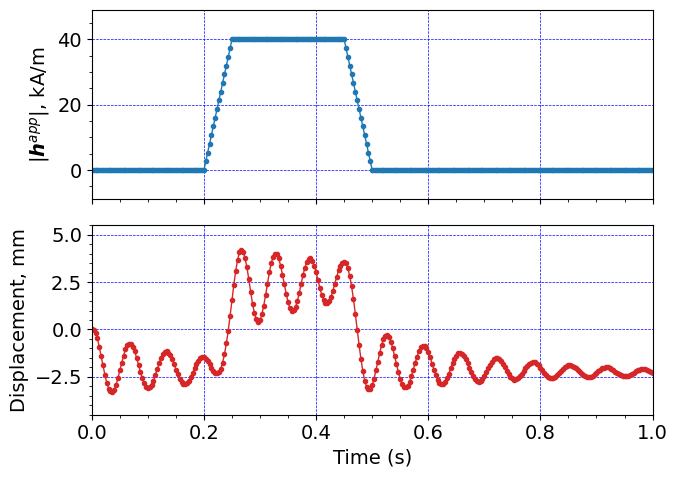

In [33]:
# Set plot font to size 14
font = {'size'   : 14}
plt.rc('font', **font)

# Get array of default plot colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors     = prop_cycle.by_key()['color']

# Only plot as far as we have time history data
ind = np.argmax(timeHist0) + 1

fig, (ax1, ax2) = plt.subplots(2,1, sharex='col')

ax2.plot(timeHist0[0:ind], timeHist2[0:ind], c=colors[3], linewidth=1.0, marker='.')
ax2.grid(linestyle="--", linewidth=0.5, color='b')
ax2.set_ylabel(r'Displacement, mm')
ax2.set_xlabel('Time (s)')
from matplotlib.ticker import AutoMinorLocator,FormatStrFormatter
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.set_xlim(0,1.0)
ax2.set_ylim(-4.5,5.5)

ax1.plot(timeHist0[0:ind], timeHist1[0:ind]/float(mu0)*1.0e3, c=colors[0], linewidth=1.0, marker='.')
ax1.grid(linestyle="--", linewidth=0.5, color='b')
ax1.set_ylabel(r'$\vert \boldsymbol{h}^{app} \vert$, kA/m')
from matplotlib.ticker import AutoMinorLocator,FormatStrFormatter
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.set_ylim(-9, 49)
#plt.show()


fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
plt.savefig("results/trilayer_displacement_time_curves.png", dpi=600)

In [34]:
# # MOVIE GENERATION:
# from matplotlib.animation import FuncAnimation
# from matplotlib.ticker import AutoMinorLocator,FormatStrFormatter
        
# fig, (ax1, ax2) = plt.subplots(2,1, sharex='col')
# # plt.figure()
# # fig = plt.gcf()
# fig.set_size_inches(7,5)
# # ax=fig.gca()  
    
# def animate(i):
#     plt.cla()



#     ax2.plot(timeHist0[0:i], timeHist2[0:i], c=colors[3], linewidth=3.0)
#     ax2.grid(linestyle="--", linewidth=0.5, color='b')
#     ax2.set_ylabel(r'Displacement, mm')
#     ax2.set_xlabel('Time (s)')

#     ax2.xaxis.set_minor_locator(AutoMinorLocator())
#     ax2.yaxis.set_minor_locator(AutoMinorLocator())
#     ax2.set_xlim(0,1.0)
#     ax2.set_ylim(-4.5,5.5)  

#     ax1.plot(timeHist0[0:i], timeHist1[0:i]/float(mu0)*1.0e3, c=colors[0], linewidth=3.0)
#     ax1.grid(linestyle="--", linewidth=0.5, color='b')
#     ax1.set_ylabel(r'$\vert \boldsymbol{h}^{app} \vert$, kA/m')
#     ax1.xaxis.set_minor_locator(AutoMinorLocator())
#     ax1.yaxis.set_minor_locator(AutoMinorLocator())
#     ax1.set_ylim(-5, 65)

# set_fps = 30
# ani = FuncAnimation(fig, animate, interval=1000/set_fps, save_count=ind+1)

# f = r"videos_screenshots/beam_curve.mp4"
# # writervideo = FFMpegWriter(fps=set_fps) 
# # ani.save(f, writer=writervideo)#, dpi=600)
# ani.save(f, fps=set_fps)#, dpi=600)
# plt.show()

In [35]:
# timeHist2[ind-2]

In [36]:
# stressData = np.array([timeHist1[0:ind], timeHist2[0:ind]])
# np.savetxt("results/trilayer_bend_data_air.csv", stressData, delimiter=",")

In [37]:

# plt.figure()
# plt.axvline(0, c='k', linewidth=1.)
# plt.axhline(0, c='k', linewidth=1.)
# plt.plot(float(mu0)*timeHist1[0:ind]/1e3, timeHist4[0:ind], linewidth=2.0,\
#          color=colors[0], label=r'$|\mathbf{b}|$')
# plt.plot(float(mu0)*timeHist1[0:ind]/1e3, timeHist3[0:ind]*float(mu0)/1e3, linewidth=2.0,\
#          color=colors[1], label=r'$\mu_0\, |\mathbf{h}|$')
# plt.plot(float(mu0)*timeHist1[0:ind]/1e3, timeHist5[0:ind]*float(mu0)/1e3, linewidth=2.0,\
#          color=colors[2], label=r'$\mu_0\, |\mathbf{m}|$')
# plt.axis('tight')
# # plt.ylabel(r"$|\mathbf{b}| , \ \mu_0\,|\mathbf{h}|, \ \mu_0\,|\mathbf{m}|$, Teslas")
# plt.ylabel(r"Internal field strength (Teslas)")
# plt.xlabel(r"$\mu_0 \, |\mathbf{h}^{app}|$  (Teslas)")
# plt.grid(linestyle="--", linewidth=0.5, color='b')
# # plt.ylim(0,1.6)
# # plt.xlim(0,1.3)
# plt.legend()

# fig = plt.gcf()
# fig.set_size_inches(7,5)
# plt.tight_layout()
# plt.savefig("results/trilayer_air_fields.png", dpi=600)